# reproducing the issue here:

The catalog for the psf stars was retrieved from: https://cmu.app.box.com/s/gdduapkhibt8kx86etvulglyr1xl422t and the shape catalog was retreived as described here: https://hsc-release.mtk.nao.ac.jp/doc/index.php/s16a-shape-catalog-pdr2/<br> this data was compiled into 1 file.

We write a function to load each catalog here:

In [12]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [43]:
# tweaks were made here to match definitions to hamana..
# primarily de = emod-epsf rather than epsf-emod definition in des and TXPipe

In [13]:
def load_stars(stype):
    with h5py.File("./star_catalog_hscy1_allfields.h5","r") as f:
        g      = f["stars"]
        ra     = g["ra"][:][g[f"calib_psf_{stype}"][:] == 1.0]
        dec    = g["dec"][:][g[f"calib_psf_{stype}"][:] == 1.0]
        e1psf  = g["measured_e1"][:][g[f"calib_psf_{stype}"][:] == 1.0]
        e2psf  = g["measured_e2"][:][g[f"calib_psf_{stype}"][:] == 1.0]
        e1mod  = g["model_e1"][:][g[f"calib_psf_{stype}"][:] == 1.0]
        e2mod  = g["model_e2"][:][g[f"calib_psf_{stype}"][:] == 1.0]
        T_frac =(g["measured_T"][:][g[f"calib_psf_{stype}"][:] == 1.0] - g["model_T"][:][g[f"calib_psf_{stype}"][:] == 1.0]) / g["model_T"][:][g[f"calib_psf_{stype}"][:] == 1.0]
        #de1    = e1psf - e1mod
        #de2    = e2psf - e2mod
        de1    = e1mod - e1psf
        de2    = e2mod - e2psf
        e_psf  = np.array((e1psf, e2psf))
        e_mod  = np.array((e1mod,e2mod))
        de_psf = np.array((de1, de2))
        del e1mod, e2mod, e1psf, e2psf, de1,de2
    f.close()

    return ra, dec, e_psf, e_mod, de_psf, T_frac

In [22]:
def apply_lensfit_calibration(g1, g2, weight, c1=0, c2=0, sigma_e=0, m=0):
    w_tot = np.sum(weight)
    m = np.sum(weight * m) / w_tot  # if m not provided, default is m=0, so one_plus_K=1
    one_plus_K = 1.0 + m
    R = 1.0 - np.sum(weight * sigma_e) / w_tot
    g1 = (1.0 / (one_plus_K)) * ((g1 / R) - c1)
    g2 = (1.0 / (one_plus_K)) * ((g2 / R) - c2)
    return g1, g2, weight, one_plus_K

In [41]:
#load galaxies as defined in TXPipe Tau stats stage..

In [27]:

def load_galaxies():

    with h5py.File("/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/hscy1/shear_cat_FULLCAT.h5","r") as f:
        with h5py.File("../../TXPipe/data/hscy1/outputs/shear_tomography_catalog.hdf5") as g:
            source_bin = g["tomography/bin"][:]
            mask = source_bin != -1
            ra = f["shear/ra"][:][mask]
            dec = f["shear/dec"][:][mask]
            g1 = f["shear/g1"][:][mask]
            g2 = f["shear/g2"][:][mask]
            weight = f["shear/weight"][:][mask]
            sigma_e = f["shear/sigma_e"][:][mask]
            m       = f["shear/m"][:][mask]
            g1, g2, weight, _ = apply_lensfit_calibration(g1      = g1,
                                                          g2      = g2,
                                                          weight  = weight,
                                                          sigma_e = sigma_e,
                                                          m       = m
                                                          )
        g.close()
    f.close()

    return ra, dec, g1, g2, weight

In [24]:
ra, dec, e_psf, e_mod, de_psf, T_f = load_stars(stype='reserved')


In [ ]:
# tau calc

In [25]:
def compute_all_tau(gra, gdec, g, gw, sra, sdec, e_mod, de_psf):
    '''
    Compute tau0, tau2
    Both need to be computed at once due to covariance.
    gra    : RA of galaxies
    gdec   : DEC of galaxies
    g      : shear for observed galaxies np.array((e1, e2))
    gw     : weights

    sra    : RA of stars
    sdec   : DEC of stars

    e_mod  : model ellipticities of PSF               -- np.array((e1mod, e2mod))
    de_psf : e_psf-e_mod                              -- np.array((e1psf, e2psf))
    '''

    import treecorr
    print("starting tau calculation...")
    p = e_mod
    q = de_psf

    sra, sdec = np.array((sra, sdec)) # Get ra/dec for specific stars
    p = np.array(( [p[0], p[1]]))     # Get p for specific stars
    q = np.array(( [q[0], q[1]]))     # Get q for specific stars

    
    # Load all catalogs
    catg = treecorr.Catalog(ra=gra, dec=gdec, g1=g[0], g2=g[1], w=gw, ra_units="deg", dec_units="deg",npatch=150) # galaxy shear
    catp = treecorr.Catalog(ra=sra, dec=sdec, g1=p[0], g2=p[1],w=np.ones(len(sra)), ra_units="deg", dec_units="deg",patch_centers=catg.patch_centers) # e_model
    catq = treecorr.Catalog(ra=sra, dec=sdec, g1=q[0], g2=q[1],w=np.ones(len(sra)), ra_units="deg", dec_units="deg",patch_centers=catg.patch_centers) # (e_* - e_model)
    del p, q

    # Compute all corrleations
    corr0 = treecorr.GGCorrelation(min_sep       = 2,
                                  max_sep       = 150,
                                  nbins         = 16,
                                  bin_slop      = 0.00,
                                   sep_units     = "arcmin")
    corr0.process(catg, catp)
    corr2 = treecorr.GGCorrelation(min_sep       = 2,
                                  max_sep       = 150,
                                  nbins         = 16,
                                  bin_slop      = 0.00,
                                   sep_units     = "arcmin")
    corr2.process(catg, catq)

    del catg, catp, catq,  

    return corr0.meanr, corr0.xip, corr0.xim, corr2.xip, corr2.xim, corr0.varxip**0.5, corr0.varxim**0.5,corr2.varxip**0.5,corr2.varxim**0.5

Plotted in comparison to Hamana et. al 2019 figure 19.

In [28]:
gra, gdec, g1, g2, gw = load_galaxies()
g = [g1,g2]


In [44]:
#measuring tau with TXPipe's method of loading galaxies 

In [29]:
tht_, c0p_, c0m_, c2p_, c2m_, c0vsnp_, c0vsnm_, c2vsnp_, c2vsnm_ = compute_all_tau(gra, gdec, g, gw, ra, dec, e_mod, de_psf)


starting tau calculation...


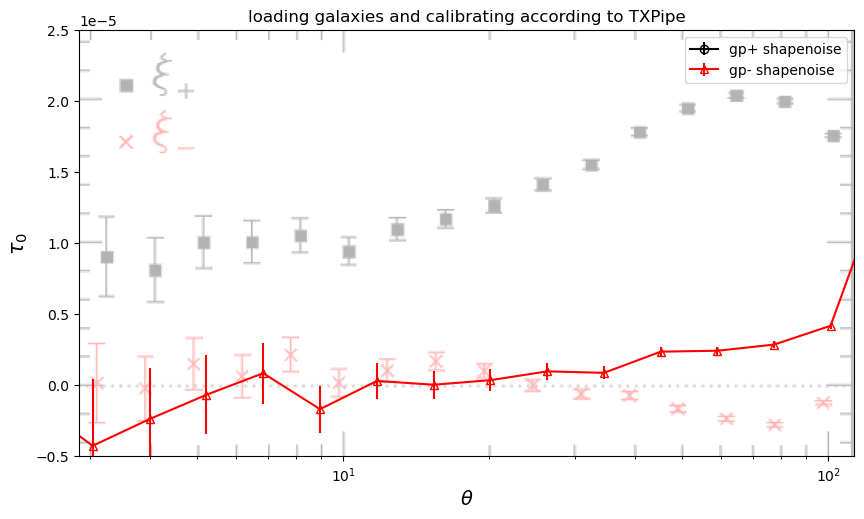

In [50]:
# plot

#set first axes
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(10,10))
img = plt.imread("Hamana2019/Xi_gp.png")

ax = fig.add_subplot(1,1,1)
ax.imshow(img,  aspect='equal',alpha=0.3)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=True)
newax.patch.set_alpha(0.0)
newax.set_xlim((2.85,113))

newax.set_ylim((-0.5e-5,2.5e-5))
newax.set_xlabel(r'$\theta\ [{\rm arcmin}]$',size=14)
newax.set_ylabel(r'$\tau_{0+}$',size=15)
newax.set_xscale('log')

#Change formatting of xticks
newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
nbins=16
plt.errorbar(tht_,c0p_,c0vsnp_,marker='o',mfc='None',color='black',label='gp+ shapenoise')
plt.errorbar(tht_,c0m_,c0vsnm_,marker='^',mfc='None',color='red',label='gp- shapenoise')
plt.title('loading galaxies and calibrating according to TXPipe')
plt.xscale('log')
plt.ylabel(r'$\tau_0$')
plt.xlabel(r'$\theta$')
plt.legend()
plt.show()

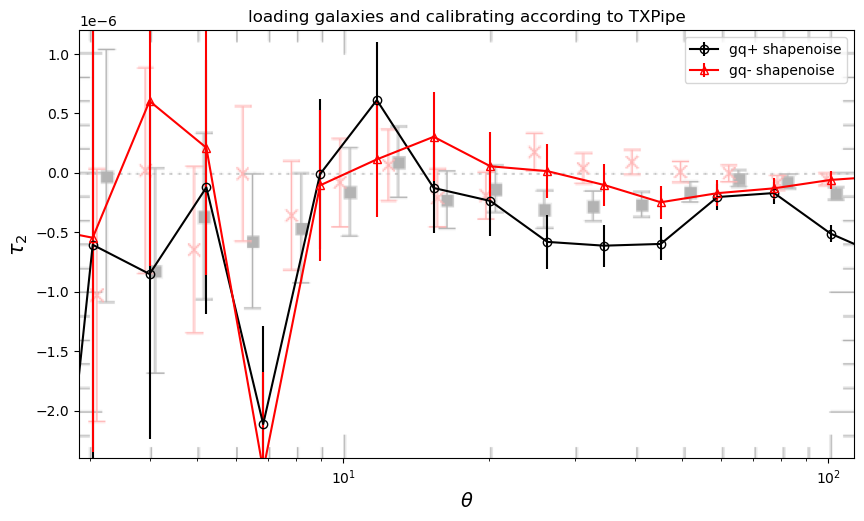

In [51]:
#set first axes
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(10,10))
img = plt.imread("Hamana2019/Xi_gq.png")

ax = fig.add_subplot(1,1,1)
ax.imshow(img,  aspect='equal',alpha=0.3)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=True)
newax.patch.set_alpha(0.0)
newax.set_xlim((2.85,113))

newax.set_ylim((-2.4e-6,1.2e-6))
newax.set_xlabel(r'$\theta\ [{\rm arcmin}]$',size=14)
newax.set_ylabel(r'$\tau_{0+}$',size=15)
newax.set_xscale('log')
#Change formatting of xticks
newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
nbins=16
plt.errorbar(tht_,c2p_,c2vsnp_,marker='o',mfc='None',color='black',label='gq+ shapenoise')
plt.errorbar(tht_,c2m_,c2vsnm_,marker='^',mfc='None',color='red',label='gq- shapenoise')
plt.title('loading galaxies and calibrating according to TXPipe')
plt.xscale('log')
plt.ylabel(r'$\tau_2$')
plt.xlabel(r'$\theta$')
plt.legend()
plt.show()

In [49]:
# loading the binned shear catalog created by TXPipe (all fields)

In [33]:
allgra = np.array([])
allgdec= np.array([])
allg1  = np.array([])
allg2  = np.array([])
allgw  = np.array([])

for i in range(0,4):
    print(i)
    d = '../../TXPipe/data/hscy1/outputs/'
    with h5py.File(d+'binned_shear_catalog.hdf5','r') as f:
        g = f[f'shear/bin_{i}']
        allgra  = np.concatenate([allgra, g['ra'] ])
        allgdec = np.concatenate([allgdec,g['dec']])
        allg1   = np.concatenate([allg1  ,g['g1'] ])
        allg2   = np.concatenate([allg2  ,g['g2']])
        allgw   = np.concatenate([allgw  ,g['weight'] ])

0
1
2
3


In [34]:
tht_1, c0p_1, c0m_1, c2p_1, c2m_1, c0vsnp_1, c0vsnm_1, c2vsnp_1, c2vsnm_1 = compute_all_tau(allgra, allgdec, [allg1,allg2], allgw, ra, dec, e_mod, de_psf)


starting tau calculation...


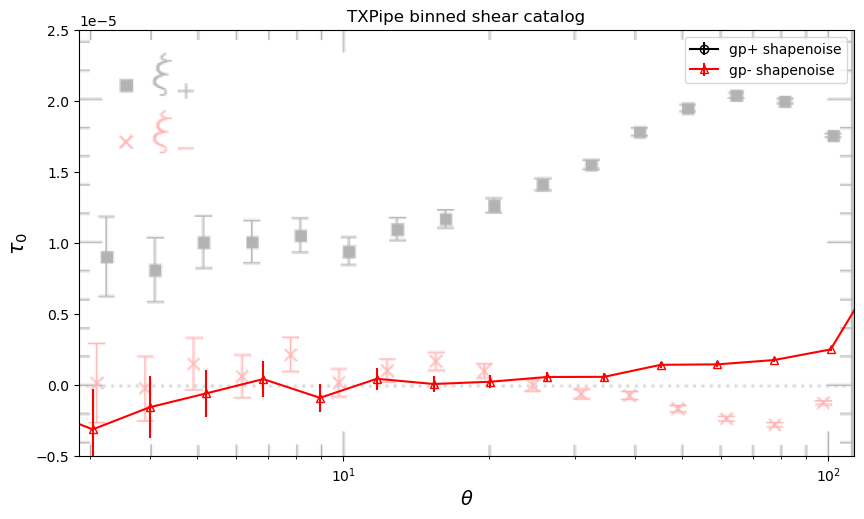

In [52]:
# plot

#set first axes
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(10,10))
img = plt.imread("Hamana2019/Xi_gp.png")

ax = fig.add_subplot(1,1,1)
ax.imshow(img,  aspect='equal',alpha=0.3)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=True)
newax.patch.set_alpha(0.0)
newax.set_xlim((2.85,113))

newax.set_ylim((-0.5e-5,2.5e-5))
newax.set_xlabel(r'$\theta\ [{\rm arcmin}]$',size=14)
newax.set_ylabel(r'$\tau_{0+}$',size=15)
newax.set_xscale('log')

#Change formatting of xticks
newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
nbins=16
plt.errorbar(tht_1,c0p_1,c0vsnp_1,marker='o',mfc='None',color='black',label='gp+ shapenoise')
plt.errorbar(tht_1,c0m_1,c0vsnm_1,marker='^',mfc='None',color='red',label='gp- shapenoise')
plt.title('TXPipe binned shear catalog')
plt.xscale('log')
plt.ylabel(r'$\tau_0$')
plt.xlabel(r'$\theta$')
plt.legend()
plt.show()

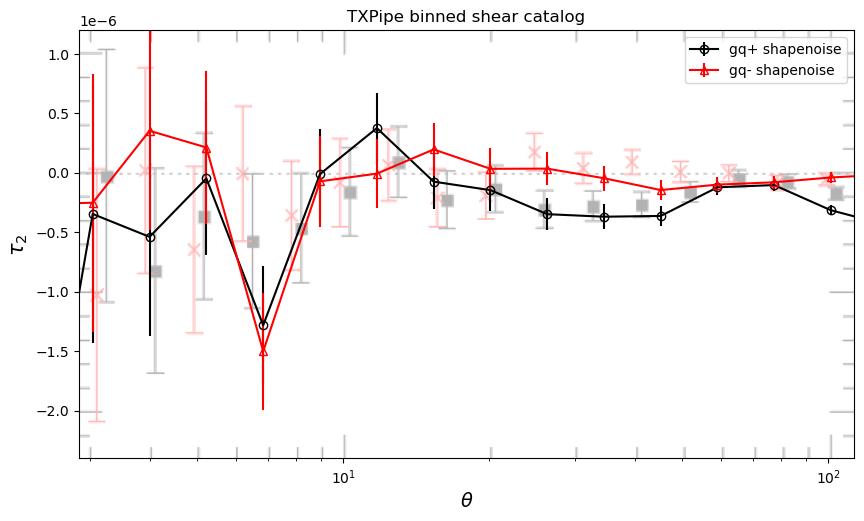

In [53]:
#set first axes
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(10,10))
img = plt.imread("Hamana2019/Xi_gq.png")

ax = fig.add_subplot(1,1,1)
ax.imshow(img,  aspect='equal',alpha=0.3)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=True)
newax.patch.set_alpha(0.0)
newax.set_xlim((2.85,113))

newax.set_ylim((-2.4e-6,1.2e-6))
newax.set_xlabel(r'$\theta\ [{\rm arcmin}]$',size=14)
newax.set_ylabel(r'$\tau_{0+}$',size=15)
newax.set_xscale('log')
#Change formatting of xticks
newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
nbins=16
plt.errorbar(tht_1,c2p_1,c2vsnp_1,marker='o',mfc='None',color='black',label='gq+ shapenoise')
plt.errorbar(tht_1,c2m_1,c2vsnm_1,marker='^',mfc='None',color='red',label='gq- shapenoise')
plt.title('TXPipe binned shear catalog')
plt.xscale('log')
plt.ylabel(r'$\tau_2$')
plt.xlabel(r'$\theta$')
plt.legend()
plt.show()

In [37]:
allgra = np.array([])
allgdec= np.array([])
allg1  = np.array([])
allg2  = np.array([])
allgw  = np.array([])

for i in range(0,4):
    print(i)

    d = '/global/cfs/cdirs/lsst/groups/WL/users/yomori/scratch/HSC/hsc2txpipe/'
    x = np.load(d+'binned_shear_catalog_allfields_zbin%d.npz'%(i+1))
    allgra  = np.concatenate([allgra, x['ra'] ])
    allgdec = np.concatenate([allgdec,x['dec']])
    allg1   = np.concatenate([allg1  ,x['g1'] ])
    allg2   = np.concatenate([allg2  ,x['g2']])
    allgw   = np.concatenate([allgw  ,x['gw'] ])

0
1
2
3


In [38]:
tht_y, c0p_y, c0m_y, c2p_y, c2m_y, c0vsnp_y, c0vsnm_y, c2vsnp_y, c2vsnm_y = compute_all_tau(allgra, allgdec, [allg1,allg2], allgw, ra, dec, e_mod, de_psf)



starting tau calculation...


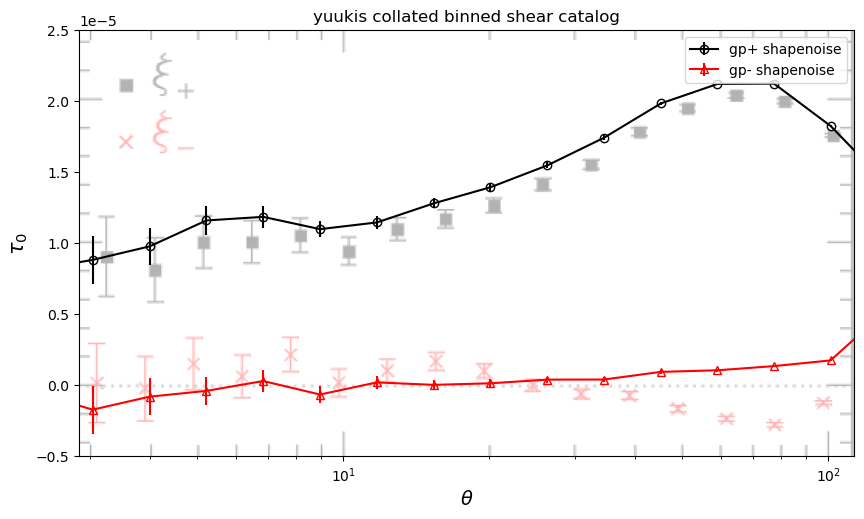

In [54]:
# plot

#set first axes
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(10,10))
img = plt.imread("Hamana2019/Xi_gp.png")

ax = fig.add_subplot(1,1,1)
ax.imshow(img,  aspect='equal',alpha=0.3)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=True)
newax.patch.set_alpha(0.0)
newax.set_xlim((2.85,113))

newax.set_ylim((-0.5e-5,2.5e-5))
newax.set_xlabel(r'$\theta\ [{\rm arcmin}]$',size=14)
newax.set_ylabel(r'$\tau_{0+}$',size=15)
newax.set_xscale('log')

#Change formatting of xticks
newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
nbins=16
plt.errorbar(tht_y,c0p_y,c0vsnp_y,marker='o',mfc='None',color='black',label='gp+ shapenoise')
plt.errorbar(tht_y,c0m_y,c0vsnm_y,marker='^',mfc='None',color='red',label='gp- shapenoise')
plt.title('yuukis collated binned shear catalog')
plt.xscale('log')
plt.ylabel(r'$\tau_0$')
plt.xlabel(r'$\theta$')
plt.legend()
plt.show()

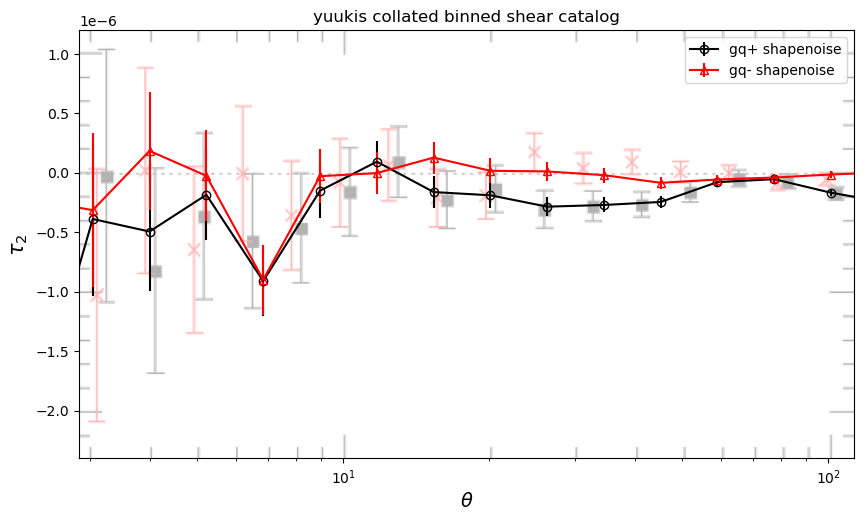

In [55]:
#set first axes
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(10,10))
img = plt.imread("Hamana2019/Xi_gq.png")

ax = fig.add_subplot(1,1,1)
ax.imshow(img,  aspect='equal',alpha=0.3)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=True)
newax.patch.set_alpha(0.0)
newax.set_xlim((2.85,113))

newax.set_ylim((-2.4e-6,1.2e-6))
newax.set_xlabel(r'$\theta\ [{\rm arcmin}]$',size=14)
newax.set_ylabel(r'$\tau_{0+}$',size=15)
newax.set_xscale('log')
#Change formatting of xticks
newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
nbins=16
plt.errorbar(tht_y,c2p_y,c2vsnp_y,marker='o',mfc='None',color='black',label='gq+ shapenoise')
plt.errorbar(tht_y,c2m_y,c2vsnm_y,marker='^',mfc='None',color='red',label='gq- shapenoise')
plt.title('yuukis collated binned shear catalog')
plt.xscale('log')
plt.ylabel(r'$\tau_2$')
plt.xlabel(r'$\theta$')
plt.legend()
plt.show()